### Tuning Parameters

In [1]:
# Define HOG parameters
p_HOG = {'orient':9, 'pix_per_cell':8, 'cell_per_block':2}

### Library Import and Data Read

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from skimage import color, exposure
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [3]:
cars = glob.glob('./DATASETS/vehicles/*/*.png')
notcars = glob.glob('./DATASETS/non-vehicles/*/*.png')

In [4]:
# cars = glob.glob('./DATASETS/vehicles_smallset/*/*.jpeg')
# notcars = glob.glob('./DATASETS/non-vehicles_smallset/*/*.jpeg')

### Feature Extraction

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return features

# def my_hog():

In [6]:
def extract_features(img_name):
    img = cv2.imread(img_name)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features_hog = hog(img_gray,
                       orientations=p_HOG['orient'],
                       pixels_per_cell=(p_HOG['pix_per_cell'], p_HOG['pix_per_cell']),
                       cells_per_block=(p_HOG['cell_per_block'], p_HOG['cell_per_block']),
                       visualise=False, feature_vector=True)
    features_spatial = bin_spatial(img)
    features_color_hist = color_hist(img)
    return (np.concatenate((features_hog, features_spatial, features_color_hist)))

In [7]:
features_list = []

for car in cars:
    features = extract_features(car)
    features_list.append(features)
    
for notcar in notcars:
    features = extract_features(notcar)
    features_list.append(features)
    
features_array = np.asarray(features_list)
features_array.shape

(17760, 4932)

### Feature Normalization


In [8]:
## why not vstack?
# y = np.vstack((np.ones((5,1)), np.zeros((4,1))))

In [9]:
y_data = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

In [10]:
print(y_data.shape)

(17760,)


In [11]:
def scale_features(features):
    # Fit a per-column scaler
    XScaler = StandardScaler().fit(features)
    # Apply the scaler to X
    return XScaler.transform(features)

In [12]:
X_data = scale_features(features_array)

In [13]:
X_data.shape

(17760, 4932)

{'boxes': [<matplotlib.lines.Line2D at 0xe856390>,
  ...],
 'caps': [<matplotlib.lines.Line2D at 0xe91edd8>,
  ...],
 'fliers': [],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0xe821b38>,
  ...],
 'whiskers': [<matplotlib.lines.Line2D at 0xe856d68>,
  ...]}

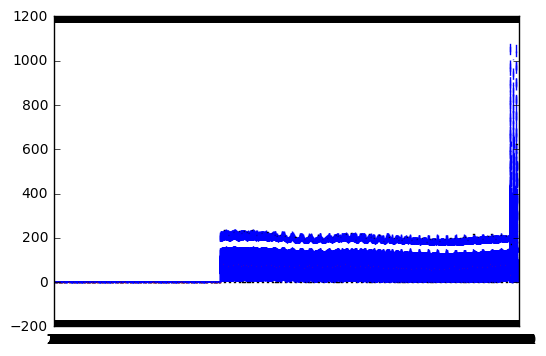

In [14]:
# plt.figure()
# plt.boxplot(features_array, 1, '')

In [16]:
# plt.figure()
# plt.boxplot(X_data, 1, '')

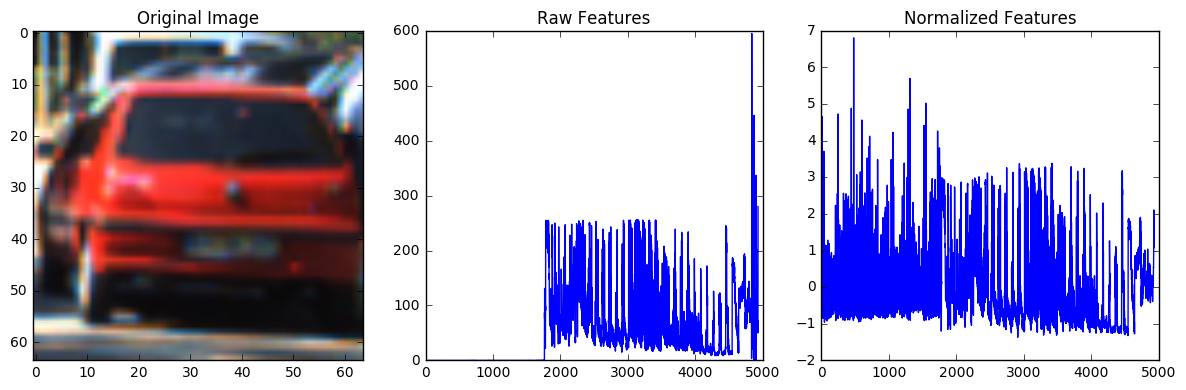

In [17]:
if len(features_array) > 0:
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(features_array[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(X_data[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

### SVM or Decision Tree or Neural Networks

In [18]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=rand_state)

In [19]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [ ]:
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

## Test Phase

In [ ]:
img = cv2.imread('./test_images/test4.jpg')
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc,  p_HOG):
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    img_roi = img[ystart:ystop,:,:]
    if scale != 1:
        imshape = img_roi.shape
        ctrans_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img_roi[:,:,0]
    ch2 = img_roi[:,:,1]
    ch3 = img_roi[:,:,2]

    # Define blocks and steps as above
    # ch1.shape[1] = 1280
    # nxblocks = 159     
    nxblocks = (ch1.shape[1] // p_HOG['pix_per_cell'])-1
    # ch1.shape[0] = 720
    # nyblocks = 89
    nyblocks = (ch1.shape[0] // p_HOG['pix_per_cell'])-1
    # number of features per block = (2**2) * 9 = 36
    nfeat_per_block = (p_HOG['cell_per_block']**2) * p_HOG['orient']
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    # nblocks_per_window = 7
    nblocks_per_window = (window // p_HOG['pix_per_cell'])-1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    # nxsteps = 76
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    # nysteps = 41
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    features_hog_frame = hog(gray,
                             orientations=p_HOG['orient'],
                             pixels_per_cell=(p_HOG['pix_per_cell'],p_HOG['pix_per_cell']),
                             cells_per_block=(p_HOG['cell_per_block'],p_HOG['cell_per_block']),
                             visualise=False, feature_vector=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            features_hog = features_hog_frame[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            xleft = xpos*p_HOG['pix_per_cell']
            ytop = ypos*p_HOG['pix_per_cell']

            # Extract the image patch
            img_patch = cv2.resize(img_roi[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            features_spatial = bin_spatial(img_patch)
            features_color_hist = color_hist(img_patch)

            # Scale features and make a prediction
#             test_features = np.hstack((spatial_features, hist_features, features_hog)).reshape(1, -1)
            test_features = np.concatenate((features_hog, features_spatial, features_color_hist))
            test_features = scale_features(test_features)
        
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1
    
out_img = find_cars(img, ystart, ystop, scale, svc, p_HOG)

plt.imshow(out_img)

In [ ]:
svc

In [ ]:
out_img.shape